# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10 with a Sigmoid non-linear activation. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to deeper models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch/Layer Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from ie590.classifiers.fc_net import *
from ie590.data_utils import get_CIFAR10_data
from ie590.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from ie590.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the ie590 directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: foward
Open the file `ie590/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# Leaky ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `leaky_relu_forward` function in ``ie590/layers.py`` and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = leaky_relu_forward(x)
print(out)
correct_out = np.array([[-5.00000000e-03, -4.09090909e-03, -3.18181818e-03, -2.27272727e-03],
                        [-1.36363636e-03, -4.54545455e-04,  4.54545455e-02,  1.36363636e-01],
                        [ 2.27272727e-01,  3.18181818e-01,  4.09090909e-01,  5.00000000e-01]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing leaky relu_forward function:')
print('difference: ', rel_error(out, correct_out))

[[-5.00000000e-03 -4.09090909e-03 -3.18181818e-03 -2.27272727e-03]
 [-1.36363636e-03 -4.54545455e-04  4.54545455e-02  1.36363636e-01]
 [ 2.27272727e-01  3.18181818e-01  4.09090909e-01  5.00000000e-01]]
Testing leaky relu_forward function:
difference:  1.3333333080993305e-09


# Leaky ReLU activation: backward
Now implement the backward pass for the Leaky ReLU activation function in the `leaky_relu_backward` function in ``ie590/layers.py`` and test your implementation using numeric gradient checking:

In [6]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: leaky_relu_forward(x)[0], x, dout)

_, cache = leaky_relu_forward(x)
dx = leaky_relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  5.704226124348278e-12


## Inline Question 1: 

You were only asked to implement Leaky ReLU, but there are a several other activation functions that one could use in neural nets, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation (``vanishing gradients problem``). Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. ReLU
2. Leaky ReLU
3. Sigmoid
4. Tanh
5. ELU

## Answer:
ReLU, Sigmoid, Tanh, and ELU have the ``vanishing gradients problem``. 

Considering 1-D case with input $x$, the $x$ that leads of vanishing gradient for each activation function is:
1. ReLU: when $x<0$
2. Sigmoid: when $x<-a$ or $x>a$, where $a$ is about $6$
3. Tanh: when $x<-a$ or $x>a$, where $a$ is about $3$
4. ELU: when $x<-a$, where $a$ is about $3$ or some small number like $ln(0.01/\alpha)$ depending on the parameter $\alpha$ in ELU

# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a Leaky ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `ie590/layer_utils.py`. 

For now take a look at the `affine_leaky_relu_forward` and `affine_leaky_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from ie590.layer_utils import affine_leaky_relu_forward, affine_leaky_relu_backward
np.random.seed(590)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_leaky_relu_forward(x, w, b)
dx, dw, db = affine_leaky_relu_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda x: affine_leaky_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_leaky_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_leaky_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_leaky_relu_forward and affine_leaky_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_leaky_relu_forward and affine_leaky_relu_backward:
dx error:  2.74794061441388e-10
dw error:  1.5594954493083734e-09
db error:  2.0033491092766538e-11


# ReLU Nonlinearity

ReLU nonlinearity is popularly used after affine layer. Hence, ReLU forward and ReLU backward functions are provided to you in ``ie590/layers.py``. You should still make sure you understand how they work by looking at their implementations in `ie590/layers.py`. Also, take a look at the `affine_relu_forward` and `affine_relu_backward` functions that are provied to you in `ie590/layers_utils.py`

# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `ie590/layers.py`.

You can make sure that the implementations are correct by running the following:

In [8]:
np.random.seed(590)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.998691606891247
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302454697401832
dx error:  7.902063613510166e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network with a sigmoid activation in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network with a leaky relu nonlinear activation using these modular implementations.

Open the file `ie590/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
np.random.seed(590)
N, D, H, C = 4, 6, 60, 8
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
[[17.11412454, 17.85929166, 18.60445878, 19.3496259,  20.09479302, 20.83996014,  21.58512726, 22.33029438],
 [17.23776228, 17.93718192, 18.63660156, 19.3360212,  20.03544084, 20.73486048,  21.43428012, 22.13369975],
 [17.36140002, 18.01507218, 18.66874434, 19.32241649, 19.97608865, 20.62976081,  21.28343297, 21.93710513],
 [17.48503776, 18.09296244, 18.70088711, 19.30881179, 19.91673647, 20.52466115,  21.13258582, 21.7405105 ]]
)
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1, 2])
loss, grads = model.loss(X, y)
correct_loss = 4.10210294077455
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 36.826586980760354
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
    print('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 2.49e-08
W2 relative error: 4.23e-10
b1 relative error: 8.71e-09
b2 relative error: 3.15e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 4.23e-07
W2 relative error: 9.02e-08
b1 relative error: 1.63e-08
b2 relative error: 1.02e-09


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `ie590/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [10]:
model = TwoLayerNet()
solver = None
best_val = -1
##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 45% accuracy on the validation set.                                        #
# You need to try several combinations of learning rates and regularizing    #
# and hidden layer sizes to obtain at least 45% accuracy on validation set.  #
# Try learning rates between 10**(-4) to 10**(-2)                            #
# Try regularization strengths between 10**(-7) to 10**(-3)                  #
# Try hidden layer sizes between 10 and 250.                                 #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
pass # Write your code here

model = TwoLayerNet(hidden_dim=100, reg=1e-3)
solver = Solver(model, data, update_rule='sgd',
                optim_config={'learning_rate': 1e-3}, lr_decay=0.95,
                num_epochs=10, batch_size=100, print_every=100)
solver.train()

# ## Tune hidden layer sizes, regularization strengths, and learning rates
# hidden_sizes = [10, 100, 200]
# regularization_strengths = [1e-5, 1e-4, 1e-3]
# learning_rates = [1e-4, 1e-3, 1e-2]

# for hidden_size in hidden_sizes:
#     for reg in regularization_strengths:
#         for lr in learning_rates:
            
#             test_model = TwoLayerNet(hidden_dim=hidden_size, reg=reg)
#             test_solver = Solver(model, data,
#                 update_rule='sgd',
#                 optim_config={
#                   'learning_rate': lr,
#                 },
#                 lr_decay=0.95,
#                 num_epochs=10, batch_size=100,
#                 print_every=100)
#             test_solver.train()
            
#             # store the best instance in model, solver, and best_val
#             if test_solver.best_val_acc > best_val:
#                 model = test_model
#                 solver = test_solver
#                 best_val = test_solver.best_val_acc

# print('best validation accuracy achieved during cross-validation: %f' % best_val)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.301232
(Epoch 0 / 10) train acc: 0.168000; val_acc: 0.144000
(Iteration 101 / 4900) loss: 1.864602
(Iteration 201 / 4900) loss: 1.662920
(Iteration 301 / 4900) loss: 1.778778
(Iteration 401 / 4900) loss: 1.741576
(Epoch 1 / 10) train acc: 0.479000; val_acc: 0.436000
(Iteration 501 / 4900) loss: 1.549449
(Iteration 601 / 4900) loss: 1.481994
(Iteration 701 / 4900) loss: 1.521671
(Iteration 801 / 4900) loss: 1.682469
(Iteration 901 / 4900) loss: 1.554676
(Epoch 2 / 10) train acc: 0.508000; val_acc: 0.478000
(Iteration 1001 / 4900) loss: 1.380330
(Iteration 1101 / 4900) loss: 1.628603
(Iteration 1201 / 4900) loss: 1.498911
(Iteration 1301 / 4900) loss: 1.271499
(Iteration 1401 / 4900) loss: 1.485613
(Epoch 3 / 10) train acc: 0.519000; val_acc: 0.492000
(Iteration 1501 / 4900) loss: 1.374665
(Iteration 1601 / 4900) loss: 1.389498
(Iteration 1701 / 4900) loss: 1.449636
(Iteration 1801 / 4900) loss: 1.425420
(Iteration 1901 / 4900) loss: 1.446023
(Epoch 4 / 10) t

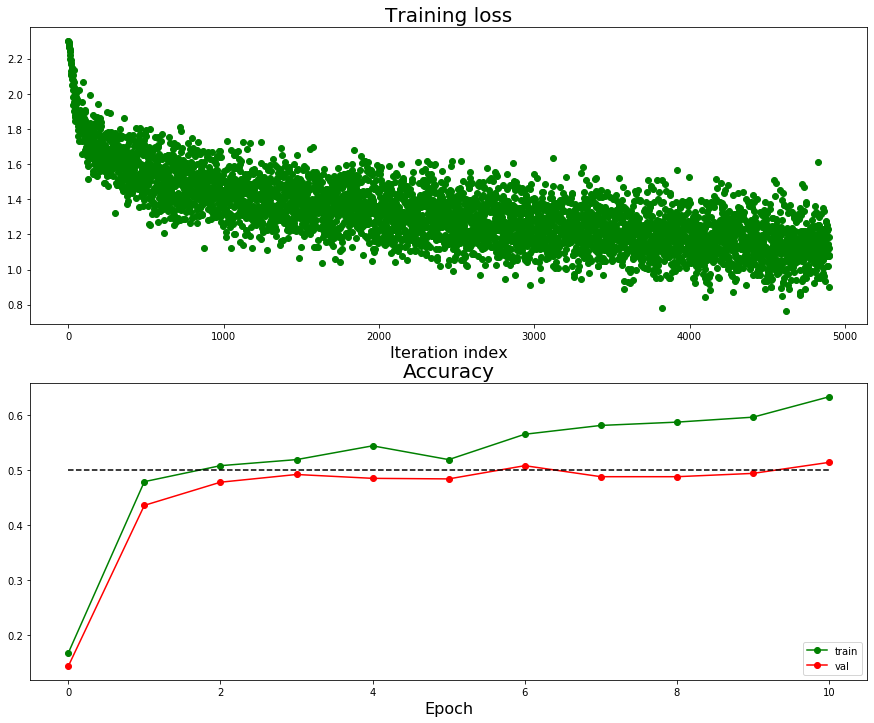

In [11]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss', fontsize = 20)
plt.plot(solver.loss_history, 'go')
plt.xlabel('Iteration index', fontsize = 16)

plt.subplot(2, 1, 2)
plt.title('Accuracy', fontsize = 20)
plt.plot(solver.train_acc_history, '-go', label='train')
plt.plot(solver.val_acc_history, '-ro', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch', fontsize = 16)
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `ie590/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [12]:
np.random.seed(590)
N, D, H1, H2, C = 3, 20, 25, 12, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)
  
    # Most of the errors should be on the order of e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3031280479106373
W1 relative error: 6.99e-05
W2 relative error: 6.53e-04
W3 relative error: 2.60e-06
b1 relative error: 1.70e-06
b2 relative error: 1.60e-05
b3 relative error: 1.43e-10
Running check with reg =  3.14
Initial loss:  6.0291288579927045
W1 relative error: 2.11e-08
W2 relative error: 4.36e-09
W3 relative error: 2.69e-09
b1 relative error: 2.56e-06
b2 relative error: 9.42e-08
b3 relative error: 2.05e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a four-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 3.816098
(Epoch 0 / 20) train acc: 0.280000; val_acc: 0.149000
(Epoch 1 / 20) train acc: 0.260000; val_acc: 0.113000
(Epoch 2 / 20) train acc: 0.560000; val_acc: 0.141000
(Epoch 3 / 20) train acc: 0.740000; val_acc: 0.151000
(Epoch 4 / 20) train acc: 0.840000; val_acc: 0.148000
(Epoch 5 / 20) train acc: 0.900000; val_acc: 0.147000
(Iteration 11 / 40) loss: 0.395753
(Epoch 6 / 20) train acc: 0.940000; val_acc: 0.149000
(Epoch 7 / 20) train acc: 0.880000; val_acc: 0.150000
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.174000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.174000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.166000
(Iteration 21 / 40) loss: 0.060019
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.162000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.162000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.164000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.163000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.167000
(Iteration 31 / 40) loss: 

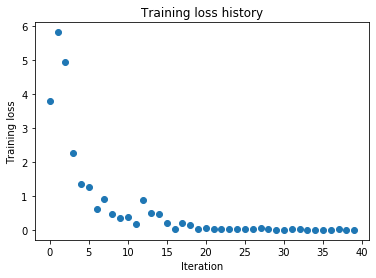

In [13]:
# TODO: Use a four-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 4e-2  # Experiment with this to make sure that the error goes to zero!
learning_rate = 1e-2  # Experiment with this to make sure that the error goes to zero!

model = FullyConnectedNet([100, 100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a six-layer network with 100 units on each layer to overfit 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 36.315844
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.099000
(Epoch 1 / 20) train acc: 0.340000; val_acc: 0.116000
(Epoch 2 / 20) train acc: 0.400000; val_acc: 0.106000
(Epoch 3 / 20) train acc: 0.540000; val_acc: 0.131000
(Epoch 4 / 20) train acc: 0.560000; val_acc: 0.114000
(Epoch 5 / 20) train acc: 0.720000; val_acc: 0.127000
(Iteration 11 / 40) loss: 1.798260
(Epoch 6 / 20) train acc: 0.840000; val_acc: 0.126000
(Epoch 7 / 20) train acc: 0.880000; val_acc: 0.120000
(Epoch 8 / 20) train acc: 0.920000; val_acc: 0.119000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.124000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.124000
(Iteration 21 / 40) loss: 0.117975
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.133000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.128000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.127000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.128000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.126000
(Iteration 31 / 40) loss:

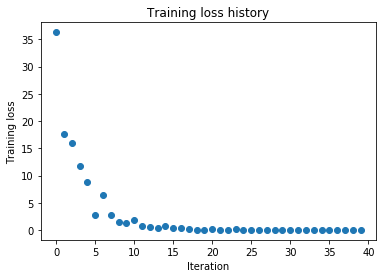

In [14]:
# TODO: Use a six-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-3  # Experiment with this to make sure that error converges to zero!
weight_scale = 8e-2   # Experiment with this to make sure that error converges to zero!

model = FullyConnectedNet([100, 100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

## Inline Question 2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
From my tests above, three-layer net is more sensitive to initialization scale. I can easily find many weight_scales and learning rates that overfit the five-layer net. 

The reason could be 1) five layer net has more layers and more parameters, thus could somewhat correct the inapproprate hyperparameters like the weight_scale and learning rate. 2) longer net has more parameters thus could better capture the patterns in the dataset, making overfitting easier as shown in aove 3-layer net and 5-layer net.


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `ie590/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [15]:
from ie590.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.632730
(Epoch 0 / 5) train acc: 0.103000; val_acc: 0.094000
(Iteration 11 / 200) loss: 2.292686
(Iteration 21 / 200) loss: 2.176596
(Iteration 31 / 200) loss: 2.182389
(Epoch 1 / 5) train acc: 0.229000; val_acc: 0.245000
(Iteration 41 / 200) loss: 2.013390
(Iteration 51 / 200) loss: 2.039805
(Iteration 61 / 200) loss: 1.968337
(Iteration 71 / 200) loss: 2.156668
(Epoch 2 / 5) train acc: 0.304000; val_acc: 0.278000
(Iteration 81 / 200) loss: 1.962470
(Iteration 91 / 200) loss: 1.896988
(Iteration 101 / 200) loss: 2.040798
(Iteration 111 / 200) loss: 1.913055
(Epoch 3 / 5) train acc: 0.379000; val_acc: 0.284000
(Iteration 121 / 200) loss: 1.852738
(Iteration 131 / 200) loss: 1.964541
(Iteration 141 / 200) loss: 1.823558
(Iteration 151 / 200) loss: 1.899347
(Epoch 4 / 5) train acc: 0.351000; val_acc: 0.307000
(Iteration 161 / 200) loss: 1.862243
(Iteration 171 / 200) loss: 1.766577
(Iteration 181 / 200) loss: 1.627801
(Iteration 191 / 200) los

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

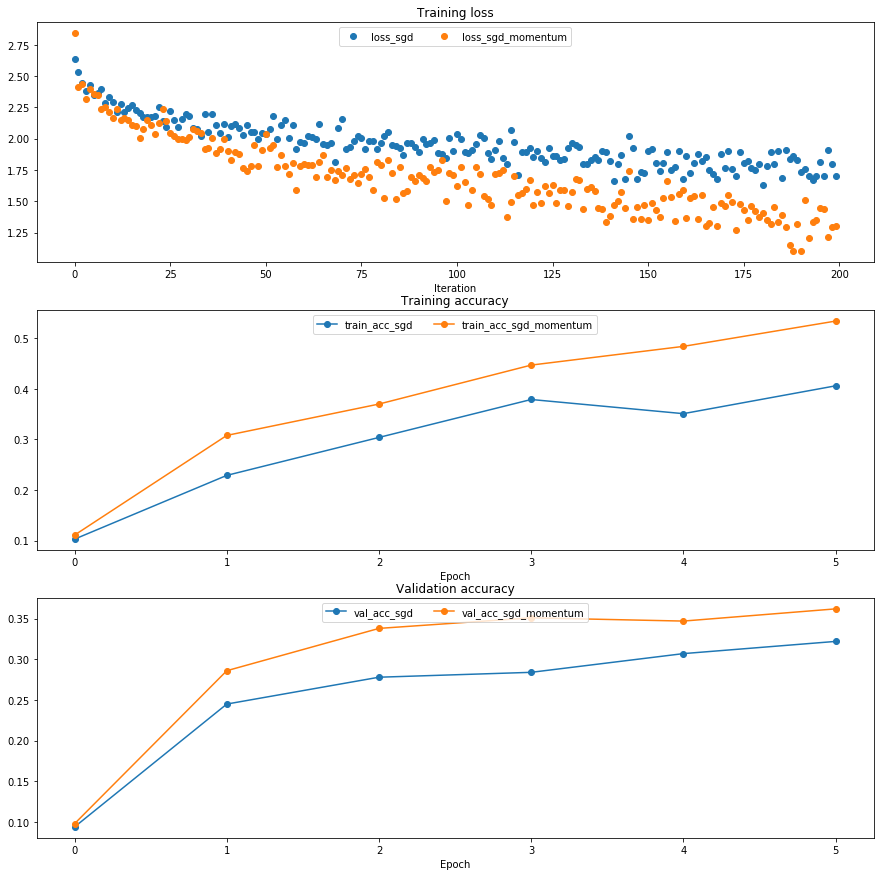

In [16]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
    
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `ie590/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [17]:
# Test RMSProp implementation
from ie590.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [18]:
# Test Adam implementation
from ie590.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 200) loss: 2.988313
(Epoch 0 / 5) train acc: 0.121000; val_acc: 0.120000
(Iteration 11 / 200) loss: 2.032706
(Iteration 21 / 200) loss: 1.873482
(Iteration 31 / 200) loss: 2.052536
(Epoch 1 / 5) train acc: 0.361000; val_acc: 0.309000
(Iteration 41 / 200) loss: 1.653792
(Iteration 51 / 200) loss: 1.693352
(Iteration 61 / 200) loss: 1.629319
(Iteration 71 / 200) loss: 1.525926
(Epoch 2 / 5) train acc: 0.459000; val_acc: 0.336000
(Iteration 81 / 200) loss: 1.564118
(Iteration 91 / 200) loss: 1.537888
(Iteration 101 / 200) loss: 1.568978
(Iteration 111 / 200) loss: 1.512165
(Epoch 3 / 5) train acc: 0.518000; val_acc: 0.381000
(Iteration 121 / 200) loss: 1.532310
(Iteration 131 / 200) loss: 1.403610
(Iteration 141 / 200) loss: 1.448947
(Iteration 151 / 200) loss: 1.435963
(Epoch 4 / 5) train acc: 0.567000; val_acc: 0.364000
(Iteration 161 / 200) loss: 1.305181
(Iteration 171 / 200) loss: 1.202389
(Iteration 181 / 200) loss: 1.148786
(Iteration 191 / 200) lo

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

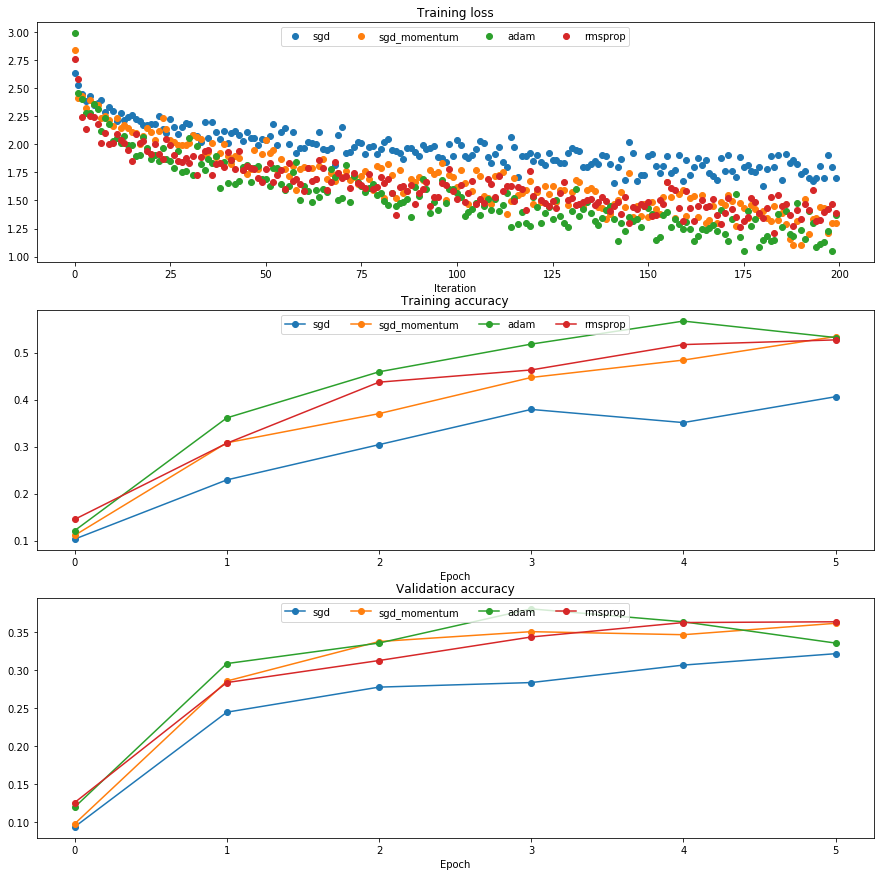

In [19]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 3:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

When you use this udpate rule, it turns out that the network is learning very slowly as the number of iterations increases. Why do you think the updates would become very small? How do you fix this problem ?


## Answer: 

Because $dw^2$ is always non-negative, the cache will become larger and larger due to the accumulation of $dw^2$, then the effective step size learning_rate / (np.sqrt(cache) + eps) will be smaller and smaller. Besides, since all previous $dw^2$ are added up, one extramely large $|dw|$ value could dramatically reduce the effective step size of all later iterations. When number of iterations increase, it is more likely to hit very large $dw^2$ at some point, and the effective step size will be smaller and smaller. All these can make the learning slower.

To fix this problem, we can use RMSProp method, which will add a decay factor $\beta$ to reduce the effect of previous $dw^2$, namely $cache += \beta*cache + (1-\beta) dw^2$. In this way, we can keep the momentum, but oldest momentum will gradually reduce to 0 and latest momentum will have larger effect. Then, the effective step size decreases slower because cache is decaying. Besides, previous extrame $dw$ value will also dimish its effect due to the decay mechanism, giving a smoother effective step size. 


# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [20]:
best_model = None
best_val = -1
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
pass # Write your code here
hidden_dims = [100] * 4

range_weight_scale = [1e-2, 2e-2, 5e-3]
range_lr = [1e-5, 5e-4, 1e-5]

best_val_acc = -1
best_weight_scale = 0
best_lr = 0

print("Training...")

for weight_scale in range_weight_scale:
    for lr in range_lr:
        model = FullyConnectedNet(hidden_dims=hidden_dims, reg=0.0,
                                 weight_scale=weight_scale)
        solver = Solver(model, data, update_rule='adam',
                        optim_config={'learning_rate': lr},
                        batch_size=100, num_epochs=5,
                        verbose=False)
        solver.train()
        val_acc = solver.best_val_acc
        
        print('Weight_scale: %f, lr: %f, val_acc: %f' % (weight_scale, lr, val_acc))
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weight_scale = weight_scale
            best_lr = lr
            best_model = model

print("Best val_acc: %f" % best_val_acc)
print("Best weight_scale: %f" % best_weight_scale)
print("Best lr: %f" % best_lr)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Training...
Weight_scale: 0.010000, lr: 0.000010, val_acc: 0.359000
Weight_scale: 0.010000, lr: 0.000500, val_acc: 0.507000
Weight_scale: 0.010000, lr: 0.000010, val_acc: 0.335000
Weight_scale: 0.020000, lr: 0.000010, val_acc: 0.413000
Weight_scale: 0.020000, lr: 0.000500, val_acc: 0.535000
Weight_scale: 0.020000, lr: 0.000010, val_acc: 0.404000
Weight_scale: 0.005000, lr: 0.000010, val_acc: 0.272000
Weight_scale: 0.005000, lr: 0.000500, val_acc: 0.512000
Weight_scale: 0.005000, lr: 0.000010, val_acc: 0.248000
Best val_acc: 0.535000
Best weight_scale: 0.020000
Best lr: 0.000500


# Test your model!
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [21]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.535
Test set accuracy:  0.523


## Inline Question 4:

List the pros and cons of the following gradient update methods: SGD, adagrad, and adam.


## Answer: 
SGD:
    Pro: 1) nature and eay to understand and apply. 
         2) only one hyperparameter to be determined, the learning rate.
    Con: 1) easily stuck in local minima or saddle points especially when the loss function has a high condition rate. 
         2) the updates are often slow and noisy.

Adagrad:
    Pro: 1) faster convering speed toward minimum .
         2) can better skip local minimum or saddle points due to the use of mementum.
    Con: 1) The updates will be smaller and smaller as the step number increases.
         2) The performance degraded a lot when there is a very large squared gradient.

Adam:
    pro: Can maintain a smoth update rate and converge even faster.
    con: Has more hyperparameters to test.

## Inline Question 4:

In which scenario is the regularization more important: 1. two layer network and 2. six layer neural network. 


## Answer: 
*The regularization in six layer neural network is more improtant. The regularization can decrease the possibility of overfitting. Six layer neural network is more complicated with more parameters, thus is more likely to overfit the trainning data.*